# Revisiting the time dependence of SEI growth
## Peter Attia, September 16, 2019
This notebook is used to explore the time dependence of SEI growth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import glob
import os
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

In [2]:
# set plotting settings
fig_size = (3.25,8.66) #ECS spec is 3.25" width
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'

## Illustration
First, we illustrate how $t^{0.5}$ models can "look good" but still not capture the true functional form.

In [3]:
# Define fitting functions
def t_onehalf(x, a, b):
    return a * x**0.5 + b

def power1(x, a, b):
    return a * x**b

def power2(x, a, b, c):
    return a * x**b + c

In [4]:
# Define wrapper function for curve fit that also returns R^2 since it's not returned by default
# https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def curve_fit_with_r_squared(f, xdata, ydata):
    popt, pcov = curve_fit(f, xdata, ydata)
    
    residuals = ydata - f(xdata, *popt)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((ydata-np.mean(ydata))**2)

    r_squared = 1 - (ss_res / ss_tot)
    
    return popt, pcov, r_squared

def curve_fit_with_adj_r_squared(f, xdata, ydata):
    popt, pcov = curve_fit(f, xdata, ydata, maxfev=10000)
    
    residuals = ydata - f(xdata, *popt)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((ydata-np.mean(ydata))**2)

    p = len(popt)
    n = len(xdata)
    r_squared = 1 - (ss_res / ss_tot)
    adj_r_squared = r_squared - (p-1)/(n-p)*(1-r_squared)
    
    return popt, pcov, adj_r_squared

def adj_r_squared(r_squared, n, p):
    return r_squared - (p-1)/(n-p)*(1-r_squared)

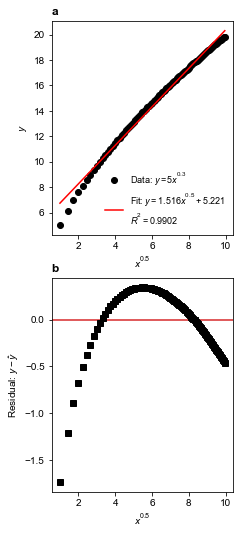

In [5]:
exponent = 0.3

x = np.arange(1,100) # example data
y = 5*x**exponent

popt, pcov, r_squared = curve_fit_with_r_squared(t_onehalf, x, y)

plt.subplots(figsize=fig_size, nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.plot(np.sqrt(x),y,'ko',
         label='Data: ' + r'$y=5x^{'+str(exponent)+'}$')
plt.plot(np.sqrt(x), t_onehalf(x, *popt), 'r-',
         label='Fit: '+ r'$y=%5.3fx^{0.5} + %5.3f$' % tuple(popt)+'\n'+r'$R^2=%3.4f$' %(r_squared))
plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'$y$')
plt.legend(frameon=False,fontsize=9)

plt.subplot(212)
plt.title('b',loc='left',weight='bold')

plt.axhline(0,color='tab:red')
plt.plot(x**0.5,y-t_onehalf(x, *popt),'ks')

plt.xlabel(r'$x^{0.5}$')
plt.ylabel(r'Residual: $y-\hat{y}$')

plt.savefig('figures/fig2.eps',bbox_inches='tight',format='eps')

## Literature data re-analysis
Next, we re-analyze literature data.
The data from the C/10, 30&deg;C series of Figure 7 of [Smith et al.](https://doi.org/10.1149/1.3557892) was extracted with [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) using three different extraction techniques. The figure is reproduced here:<br>
<img src="smith/Smith_et_al_2011_Fig7.png" width="400">

In [6]:
csvs = glob.glob('smith/Smith_et_al_2011_Fig7_30degC_Cover10*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
Smith_30C_data = []
data_shape = np.genfromtxt(csvs[0],delimiter=',').shape
x = np.zeros((data_shape[0],3))
y = np.zeros((data_shape[0],3))

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv,delimiter=',')
    Smith_30C_data.append(d)
    x[:,k] = d[:,0]
    y[:,k] = d[:,1]

Text(0, 0.5, '$Q_{irr} (mAh/g)$')

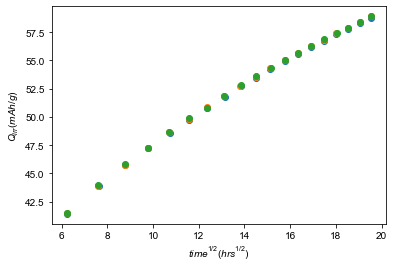

In [7]:
for d in Smith_30C_data:
    plt.plot(d[:,0],d[:,1],'o')
plt.xlabel(r'$time^{1/2} (hrs^{1/2})$')
plt.ylabel(r'$Q_{irr} (mAh/g)$')

Triplicate extractions look similar. Next we determine the relative standard error (rse) to quantify the extraction error

Mean relative standard error = 0.095%
Max relative standard error = 0.151%


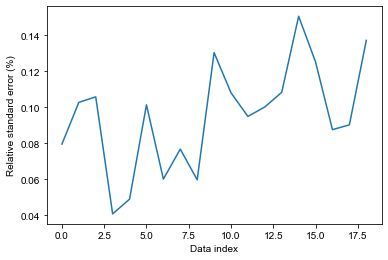

In [8]:
means = np.mean(y,axis=1)
se = 1.96*np.std(y,axis=1)/np.sqrt(3)
rse = se/means*100
plt.plot(rse)
plt.xlabel('Data index')
plt.ylabel('Relative standard error (%)')
print('Mean relative standard error = {:.3f}%'.format(np.mean(rse)))
print('Max relative standard error = {:.3f}%'.format(np.max(rse)))

Extraction errors are quite low. For now we'll assume we can accurately extract the data, although of course there could be systematic extraction errors (we don't have the true values for the true quantification)

In [9]:
x = Smith_30C_data[0][:,0]**2 # work with x in units of time, not sqrt(time)
y = Smith_30C_data[0][:,1]

popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)

print('Adjusted R^2 for at^1/2+b: %5.4f' % adj_r2_1)
print('Adjusted R^2 for at^b: %5.4f' % adj_r2_2)
print('Adjusted R^2 for at^b+c: %5.4f' % adj_r2_3)

Adjusted R^2 for at^1/2+b: 0.9913
Adjusted R^2 for at^b: 0.9996
Adjusted R^2 for at^b+c: 0.9999


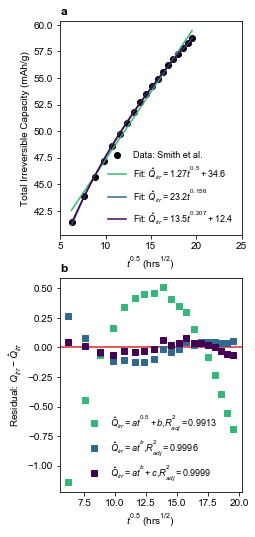

In [10]:
colors = cm.viridis(np.linspace(0, 1, 4))
colors = colors[:,0:3]

# start plotting
plt.subplots(figsize=fig_size, nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.plot(x**0.5,y,'ko',
         label='Data: Smith et al.')
plt.plot(x**0.5, t_onehalf(x, *popt1), color=colors[2,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%5.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x**0.5, power1(x, *popt2), color=colors[1,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%5.1ft^{%5.3f}$' % tuple(popt2))
plt.plot(x**0.5, power2(x, *popt3), color=colors[0,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%5.1ft^{%5.3f} + %5.1f$' % tuple(popt3))

plt.xlabel(r'$t^{0.5}$' + ' (hrs' +r'$^{1/2}$' +')')
plt.xlim((5,25))
plt.ylabel('Total Irreversible Capacity (mAh/g)')
plt.legend(frameon=False,fontsize=9)

## residual analysis
plt.subplot(212)
plt.title('b',loc='left',weight='bold')

plt.axhline(0,color='tab:red')
plt.plot(x**0.5,y-t_onehalf(x, *popt1),'s',color=colors[2,:],
        label=r'$\hat{Q}_{irr}=at^{0.5}+b$'+','+r'$R^2_{adj}=%3.4f$' %(adj_r2_1))
plt.plot(x**0.5,y-power1(x, *popt2),'s',color=colors[1,:],
        label=r'$\hat{Q}_{irr}=at^{b}$'+','+r'$R^2_{adj}=%3.4f$' %(adj_r2_2))
plt.plot(x**0.5,y-power2(x, *popt3),'s', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$'+','+r'$R^2_{adj}=%3.4f$' %(adj_r2_3))

plt.xlabel(r'$t^{0.5}$' + ' (hrs' +r'$^{1/2}$' +')')
plt.ylabel('Residual: '+ r'$Q_{irr}-\hat{Q}_{irr}$')
plt.legend(frameon=False,fontsize=9)

plt.savefig('figures/fig3.eps',bbox_inches='tight',format='eps')

Now, try prediction of last 20% of data points, using first 80% of data points for training

In [11]:
threshold = int(np.floor(np.size(x)*0.8)) # train/test threshold for indexing

# split into test/train
x_train = Smith_30C_data[0][:threshold,0]**2
y_train = Smith_30C_data[0][:threshold,1]
x_test = Smith_30C_data[0][threshold:,0]**2
y_test = Smith_30C_data[0][threshold:,1]

# fit training data
popt1 = curve_fit(t_onehalf, x_train, y_train)[0]
popt2 = curve_fit(power1, x_train, y_train)[0]
popt3 = curve_fit(power2, x_train, y_train)[0]

# calculate rmse
rmse1 = np.sqrt(mean_squared_error(y_test,t_onehalf(x_test, *popt1)))
rmse2 = np.sqrt(mean_squared_error(y_test,power1(x_test, *popt2)))
rmse3 = np.sqrt(mean_squared_error(y_test,power2(x_test, *popt3)))

print('RMSE for at^1/2+b: %5.4f' % rmse1)
print('RMSE for at^b: %5.4f' % rmse2)
print('RMSE for at^b+c: %5.4f' % rmse3)

RMSE for at^1/2+b: 1.0360
RMSE for at^b: 0.0889
RMSE for at^b+c: 0.1399


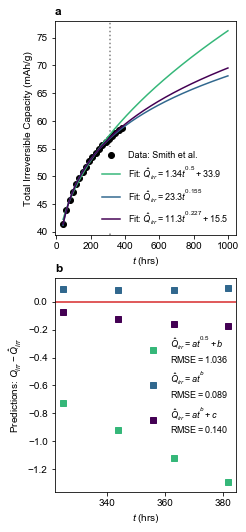

In [12]:
x_future = np.arange(np.min(x_train),1000)

# start plotting
plt.subplots(figsize=fig_size, nrows=2)
plt.subplot(211)
plt.title('a',loc='left',weight='bold')

plt.axvline(np.mean(x[threshold-1:threshold+1]),color='tab:gray',linestyle=':',zorder=0)
plt.plot(x,y,'ko', label='Data: Smith et al.')
plt.plot(x_future, t_onehalf(x_future, *popt1), color=colors[2,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%.2ft^{0.5} + %5.1f$' % tuple(popt1))
plt.plot(x_future, power1(x_future, *popt2), color=colors[1,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%.1ft^{%5.3f}$' % tuple(popt2))
plt.plot(x_future, power2(x_future, *popt3), color=colors[0,:],
         label='Fit: '+r'$\hat{Q}_{irr}=%.1ft^{%5.3f} + %5.1f$' % tuple(popt3))

plt.xlabel(r'$t$'+' (hrs)')
plt.ylabel('Total Irreversible Capacity (mAh/g)')
plt.legend(fontsize=9,framealpha=1,edgecolor='white').set_zorder(1)

## Predictions
plt.subplot(212)
plt.title('b',loc='left',weight='bold')

plt.axhline(0,color='tab:red')
plt.plot(x_test,y_test-t_onehalf(x_test, *popt1),'s', color=colors[2,:],
         label=r'$\hat{Q}_{irr}=at^{0.5}+b$'+'\nRMSE'+r'$=%3.3f$' %(rmse1))
plt.plot(x_test,y_test-power1(x_test, *popt2),'s', color=colors[1,:],
         label=r'$\hat{Q}_{irr}=at^{b}$'+'\nRMSE'+r'$=%3.3f$' %(rmse2))
plt.plot(x_test,y_test-power2(x_test, *popt3),'s', color=colors[0,:],
         label=r'$\hat{Q}_{irr}=at^{b}+c$'+'\nRMSE'+r'$=%3.3f$' %(rmse3))

plt.xlabel(r'$t$'+' (hrs)')
plt.ylabel('Predictions: '+r'$Q_{irr}-\hat{Q}_{irr}$')
plt.legend(frameon=False,fontsize=9)

plt.savefig('figures/fig4.eps',bbox_inches='tight',format='eps')

Does the exponent become closer to 0.5 at later times? Here we see how the exponent changes throughtout the dataset. We use a five-point moving window.

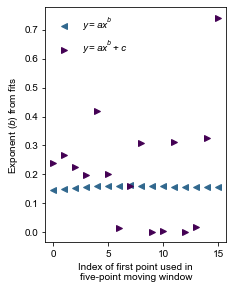

In [13]:
thresholds = np.arange(len(x)-3)
exponent2 = np.zeros(thresholds.size)
exponent3 = np.zeros(thresholds.size)

for k, threshold in enumerate(thresholds):
    # define training data
    x_train = Smith_30C_data[0][threshold:threshold+5,0]**2
    y_train = Smith_30C_data[0][threshold:threshold+5,1]

    # fit training data
    popt,pcov = curve_fit(power1, x_train, y_train)
    exponent2[k] = popt[1]
    
    popt,pcov = curve_fit(power2, x_train, y_train, maxfev=50000)
    exponent3[k] = popt[1]

plt.subplots(figsize=(3.25,4.33))
plt.plot(thresholds,exponent2,'<',color=colors[1,:],label=r'$y=ax^b$')
plt.plot(thresholds,exponent3,'>',color=colors[0,:], label=r'$y=ax^b+c$')
plt.xlabel('Index of first point used in\nfive-point moving window')
plt.ylabel('Exponent ('+r'$b$'+') from fits')
plt.legend(frameon=False)
plt.savefig('figures/fig5.eps',bbox_inches='tight',format='eps')

### Smith et al
We now look at the rest of the C/10 data in Figure 7 of Smith et al.

In [14]:
def sortKeyFunc(s):
    return os.path.basename(s)

In [15]:
# Load other Smith et al csvs
csvs = glob.glob('smith/Smith_et_al_2011_Fig7_[!30]*.{}'.format('csv')) #two-column array, x=t^0.5, y=Qirr
csvs.sort(key=sortKeyFunc) # glob returns list with arbitrary order

print(csvs)

Smith_data = []
Smith_data.append(Smith_30C_data[0]) # 30 deg C

for k, csv in enumerate(csvs):
    d = np.genfromtxt(csv,delimiter=',')
    Smith_data.append(d)

['smith/Smith_et_al_2011_Fig7_40degC_Cover10.csv', 'smith/Smith_et_al_2011_Fig7_50degC_Cover10.csv']


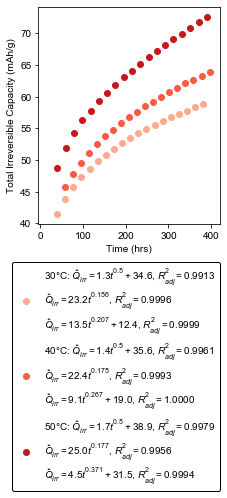

In [16]:
colors = cm.Reds(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]

# Loop through data, fit, and plot
labels = [r'$30\degree$'+'C',r'$40\degree$'+'C',r'$50\degree$'+'C']

plt.figure(figsize=(3.25,4))

for k, d in enumerate(Smith_data):
    x = d[:,0]**2
    y = d[:,1]
    
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = labels[k] + ': ' \
    + r'$\hat{Q}_{irr}=%5.1ft^{0.5} + %5.1f$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{Q}_{irr}=%5.1ft^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2 + '\n' \
    + r'$\hat{Q}_{irr}=%5.1ft^{%5.3f} + %5.1f$' % tuple(popt3) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_3
    
    plt.plot(x,y,'o',label=label,color=colors[k])
    
plt.xlabel('Time (hrs)')
plt.ylabel('Total Irreversible Capacity (mAh/g)')
plt.xlim((-5, 420))
plt.legend(bbox_to_anchor=(1.03, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/Smith.eps',bbox_inches='tight',format='eps')

### Wright et al
The 60&deg;C data was hard to extract, so we extract all but that one.
<br>
<img src="wright/Wright_et_al_2002_Fig1.png" width="600">

In [17]:
# Dataset loading wrapper
def load_dataset(author):
    csvs = glob.glob(author+'/'+author+'_et_al*.{}'.format('csv')) #two-column array
    csvs.sort(key=sortKeyFunc) # glob returns list with arbitrary order

    print(csvs)

    data = []

    for k, csv in enumerate(csvs):
        d = np.genfromtxt(csv,delimiter=',')
        data.append(d)
        
    return data

In [18]:
Wright_data = load_dataset('Wright')

['Wright/Wright_et_al_2002_Fig1_40C.csv', 'Wright/Wright_et_al_2002_Fig1_50C.csv', 'Wright/Wright_et_al_2002_Fig1_70C.csv']


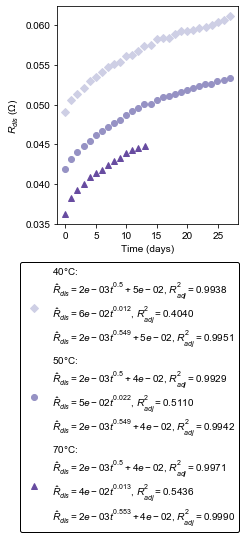

In [19]:
colors = cm.Purples(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['D','o','^']

# Loop through data, fit, and plot
labels = [r'$40\degree$'+'C',r'$50\degree$'+'C',r'$70\degree$'+'C']

plt.figure(figsize=(3.25,4))

for k, d in enumerate(Wright_data):
    x = d[:,0]**2
    y = d[:,1]
    
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = labels[k] + ':\n' \
    + r'$\hat{R}_{dis}=%5.0et^{0.5} + %5.0e$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{R}_{dis}=%5.0et^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2 + '\n' \
    + r'$\hat{R}_{dis}=%5.0et^{%5.3f} + %5.0e$' % tuple(popt3) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_3
    
    plt.plot(x,y,label=label,color=colors[k],marker=markers[k],linestyle='None')
    
plt.xlabel('Time (days)')
plt.ylabel(r'$R_{dis}$' + ' ' +r'$(\Omega)$')
plt.legend(bbox_to_anchor=(1.03, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/Wright.eps',bbox_inches='tight',format='eps')

### Broussely et al
We use the "proto" datasets here
<br>
<img src="broussely/Broussely_et_al_2001_Fig6.png" width="600">

In [20]:
# Load Broussely et al csvs
Broussely_data = load_dataset('Broussely')

['Broussely/Broussely_et_al_2001_Fig6_30C.csv', 'Broussely/Broussely_et_al_2001_Fig6_60C.csv']


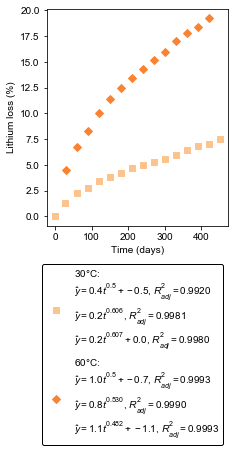

In [21]:
colors = cm.Oranges(np.linspace(0.3, 1, 4))
colors = colors[:,0:3]
markers = ['s','D']

# Loop through data, fit, and plot
labels = [r'$30\degree$'+'C',r'$60\degree$'+'C']

plt.figure(figsize=(3.25,4))

for k, d in enumerate(Broussely_data):
    x = d[:,1] # x and y are switched for this plot
    y = d[:,0]
    
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = labels[k] + ':\n' \
    + r'$\hat{y}=%5.1ft^{0.5} + %5.1f$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{y}=%5.1ft^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2 + '\n' \
    + r'$\hat{y}=%5.1ft^{%5.3f} + %5.1f$' % tuple(popt3) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_3
    
    plt.plot(x,y,label=label,color=colors[k],marker=markers[k],linestyle='None')
    
plt.xlabel('Time (days)')
plt.ylabel('Lithium loss (%)')
plt.legend(bbox_to_anchor=(1, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/Broussely.eps',bbox_inches='tight',format='eps')

### Smith et al (paper 2)
We analyze the data in Figure 2b
<br>
<img src="smith2/Smith2_et_al_2011_Fig8.png" width="600">

In [22]:
# Load Smith et al (2) csvs
Smith2_data = load_dataset('Smith2')

['Smith2/Smith2_et_al_2011_Fig8b.csv']


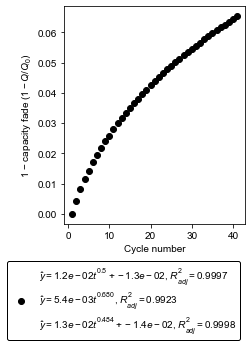

In [23]:
plt.figure(figsize=(3.25,4))

for k, d in enumerate(Smith2_data):
    x = np.arange(len(d))+1 # just generate cycle number data directly
    y = 1-d[:,1]/d[0,1]
    
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = \
      r'$\hat{y}=%5.1et^{0.5} + %5.1e$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{y}=%5.1et^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2 + '\n' \
    + r'$\hat{y}=%5.1et^{%5.3f} + %5.1e$' % tuple(popt3) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_3
    
    plt.plot(x,y,'ok',label=label,linestyle='None')
    
plt.xlabel('Cycle number')
plt.ylabel('1 − capacity fade ($1-Q/Q_0$)')
plt.legend(bbox_to_anchor=(1, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/Smith2.eps',bbox_inches='tight',format='eps')

### Fathi et al
Because this plot was saved as a vector plot, we can more easily extract the data. (Please publish your data in vector formats!!)
Here, we focus on Groups 3 and 4 since they have the most data
<br>
<img src="fathi/Fathi_et_al_2014_Fig2.png" width="400">

In [24]:
# Load Fathi et al csvs
Fathi_data = load_dataset('Fathi')

['Fathi/Fathi_et_al_2014_Fig2a_group3a.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group3b.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group4a.csv', 'Fathi/Fathi_et_al_2014_Fig2a_group4b.csv']


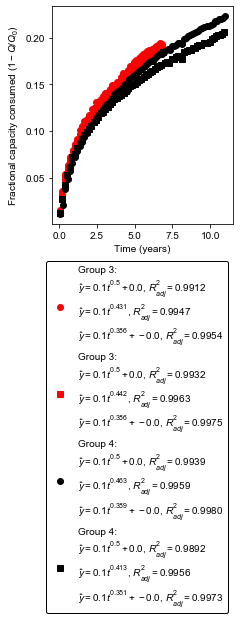

In [25]:
colors = ['or','sr','ok','sk']

# Loop through data, fit, and plot
labels = ['Group 3', 'Group 3','Group 4', 'Group 4']

plt.figure(figsize=(3.25,4))

for k, d in enumerate(Fathi_data):
    x = d[:,0]
    y = 1-d[:,1]
    
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = labels[k] + ':\n' \
    + r'$\hat{y}=%5.1ft^{0.5} + %5.1f$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{y}=%5.1ft^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2 + '\n' \
    + r'$\hat{y}=%5.1ft^{%5.3f} + %5.1f$' % tuple(popt3) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_3
    
    plt.plot(x,y,colors[k],label=label)

plt.xlabel('Time (years)')
plt.ylabel('Fractional capacity consumed (' + r'$1-Q/Q_0$' + ')')
plt.legend(bbox_to_anchor=(1, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/Fathi.eps',bbox_inches='tight',format='eps')

### Carbon black

['carbon black/cellA_Cover20_CB5.txt', 'carbon black/cellH_Cover20_CC2.txt', 'carbon black/cellI_Cover20_CC3.txt']


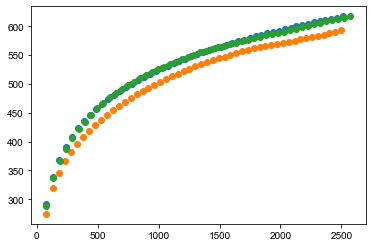

In [26]:
#Load and process data

author = 'carbon black'
txts = glob.glob(author+'/*.{}'.format('txt'))
txts.sort(key=sortKeyFunc)
print(txts)

# Divide by masses to get mAh/g
mass = [0.855,0.930,0.952] # cells A, H, I respectively

t = []
SEI = []

for k, txt in enumerate(txts):
    d = np.genfromtxt(txt,skip_header=1)
    m = mass[k]/1000 # mg -> g
    
    #Q
    Q = d[:,2]/m # mAh -> mAh/g

    # Qd and Qc vs n
    peaks = find_peaks(Q)[0]
    Qpeaks = Q[peaks]
    Qd = Qpeaks[0::2]
    Qc = Qpeaks[1::2]
    
    # t (all cells cycle at C/20, with 1C = 200 mA/g -> C/20 = 10 mA/g)
    temp_t = np.cumsum(Qpeaks)/10 # t = Q/I; (mAh/g / mA/g) -> h
    
    SEI_temp = np.cumsum(Qd[:-1] - Qc)
    
    t.append(temp_t[1::2]) # time per cycle counts after discharge
    SEI.append(SEI_temp)
    
    plt.plot(t[k],SEI[k],'o')

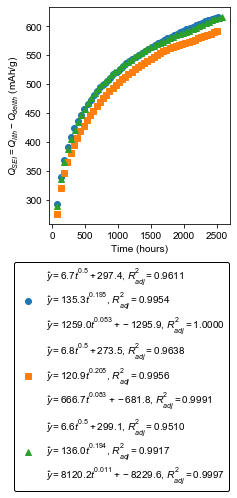

In [27]:
# Loop through data, fit, and plot: time

plt.figure(figsize=(3.25,4))

colors = ['tab:blue','tab:orange','tab:green']
markers = ['o','s','^']

for k, (x, y) in enumerate(zip(t,SEI)):
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = \
      r'$\hat{y}=%5.1ft^{0.5} + %5.1f$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{y}=%5.1ft^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2 + '\n' \
    + r'$\hat{y}=%5.1ft^{%5.3f} + %5.1f$' % tuple(popt3) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_3
    
    plt.plot(x,y,'o',label=label,color=colors[k],marker=markers[k])

plt.xlabel('Time (hours)')
plt.ylabel(r'$Q_{SEI} = Q_{lith}-Q_{delith}$' + ' (mAh/g)')
plt.legend(bbox_to_anchor=(1.02, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/CB_t.eps',bbox_inches='tight',format='eps')

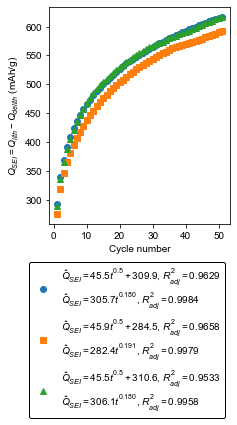

In [28]:
# Loop through data, fit, and plot: cycle number

plt.figure(figsize=(3.25,4))

for k, y in enumerate(SEI):
    x = np.arange(len(y))+1
    
    popt1,pcov1,adj_r2_1 = curve_fit_with_adj_r_squared(t_onehalf, x, y)
    popt2,pcov2,adj_r2_2 = curve_fit_with_adj_r_squared(power1, x, y)
    #popt3,pcov3,adj_r2_3 = curve_fit_with_adj_r_squared(power2, x, y)
    label = \
      r'$\hat{Q}_{SEI}=%5.1ft^{0.5} + %5.1f$' % tuple(popt1) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_1 + '\n' \
    + r'$\hat{Q}_{SEI}=%5.1ft^{%5.3f}$' % tuple(popt2) +', ' + r'$R_{adj}^2=%5.4f}$' % adj_r2_2
    
    plt.plot(x,y,'o',label=label,color=colors[k],marker=markers[k])

plt.xlabel('Cycle number')
plt.ylabel(r'$Q_{SEI} = Q_{lith}-Q_{delith}$' + ' (mAh/g)')
plt.legend(bbox_to_anchor=(1, -0.15),edgecolor='k',framealpha=1)
plt.savefig('figures/CB_cn.eps',bbox_inches='tight',format='eps')